In [1]:
import numpy as np
import pandas as pd
import torch

In [2]:
def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

seed = 1337
set_seed(seed)

In [3]:
import os
import sys

notebook_dir = os.getcwd()

root_dir = os.path.abspath(os.path.join(notebook_dir, "../../"))
sys.path.append(root_dir)

In [4]:
from dotenv import load_dotenv

load_dotenv()

from service import EnvironmentSecretService

In [5]:
from core.models.exchange import ExchangeType
from core.models.lookback import Lookback
from core.models.timeframe import Timeframe
from exchange import ExchangeFactory

In [6]:
DEFAULT_EXCHANGE = ExchangeType.BYBIT
DEFAULT_TIMEFRAME = Timeframe.FIFTEEN_MINUTES
DEFAULT_LOOKBACK = Lookback.EIGHT_MONTH

from datetime import datetime

today = datetime.now().strftime('%Y-%m-%d')

raw_df_filename = f'ocean_raw_{DEFAULT_TIMEFRAME}_{DEFAULT_LOOKBACK}_{today}.csv'
features_filename = f'ocean_features_{today}.npy'
symbol_indices_filename = f'ocean_symbol_idx_{today}.npy'
emb_filename = f'ocean_emb_{today}.npy'
volume_df_filename = f'ocean_vol_{today}.csv'
res_filename = f'ocean_res_{today}.npy'

In [7]:
exchange_factory = ExchangeFactory(EnvironmentSecretService())
exchange = exchange_factory.create(DEFAULT_EXCHANGE)

In [20]:
symbols = exchange.fetch_future_symbols()

data = []
for symbol in symbols:
    try:
        for ohlcv in exchange.fetch_ohlcv(symbol, DEFAULT_TIMEFRAME, DEFAULT_LOOKBACK):
            _timestamp, _open, _high, _low, _close, _volume = ohlcv
            data.append([symbol.name, _timestamp, _open, _high, _low, _close, _volume])
    except Exception as e:
        print(f"Error fetching data for {symbol}: {str(e)}")

symbols_df = pd.DataFrame(data, columns=['Symbol', 'Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume'])

float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
symbols_df[float_columns] = symbols_df[float_columns].astype('float32')
symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'], unit='ms')

symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)
symbols_df.to_csv(raw_df_filename, index=False)

In [45]:
symbols_df = pd.read_csv(raw_df_filename)
float_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
symbols_df[float_columns] = symbols_df[float_columns].astype('float32')

symbols_df['Timestamp'] = pd.to_datetime(symbols_df['Timestamp'])
symbols_df.sort_values(by=['Symbol', 'Timestamp'], inplace=True)

In [46]:
symbols_df.head()

,Symbol,Timestamp,Open,High,Low,Close,Volume
0,10000000AIDOGEUSDT,2024-03-05 10:45:00,0.004816,0.004816,0.004807,0.004807,400.0
1,10000000AIDOGEUSDT,2024-03-05 11:00:00,0.004807,0.006305,0.004617,0.006210,719649408.0
2,10000000AIDOGEUSDT,2024-03-05 11:15:00,0.006210,0.007224,0.005910,0.006182,743186304.0
3,10000000AIDOGEUSDT,2024-03-05 11:30:00,0.006182,0.006208,0.005710,0.005939,321725888.0
4,10000000AIDOGEUSDT,2024-03-05 11:45:00,0.005939,0.006073,0.005634,0.005765,209583600.0


In [50]:
def volume_features(df, period_14=14, period_20=20, period_30=30):
    df = df.copy()

    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Date'] = df['Timestamp'].dt.date

    grouped = df.groupby(['Symbol', 'Date'])

    df['Previous Close'] = df.groupby('Symbol')['Close'].shift(1)
    df['True Range'] = df.apply(lambda row: max(row['High'] - row['Low'], abs(row['High'] - row['Previous Close']), abs(row['Low'] - row['Previous Close'])), axis=1)
    df['Typical Price'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['Price Change'] = grouped['Close'].diff()
    df['Buy Volume'] = df['Volume'].where(df['Price Change'] > 0, 0)
    df['Sell Volume'] = df['Volume'].where(df['Price Change'] < 0, 0)
    df['VROC'] = df['Volume'].pct_change(period_14)

    df['ADV'] = grouped['Volume'].transform('mean')
    df['IVR'] = df['Volume'] / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_20).mean()).replace(0, 1e-6)
    df['Turnover_Ratio'] = df['Volume'] / df['ADV'].replace(0, 1e-6)

    df['PVT'] = df['Close'].pct_change() * df['Volume']
    df['PVT'] = df.groupby('Symbol')['PVT'].cumsum()
    df['VMO'] = (df['Volume'] - df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_14).mean())) / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_14).std()).replace(0, 1e-6)

    df['Cumulative Price * Volume'] = df['Typical Price'] * df['Volume']
    df['Cum_Volume'] = grouped['Volume'].cumsum()
    df['Cum_Price_Volume'] = grouped['Cumulative Price * Volume'].cumsum()
    df['VWAP'] = df['Cum_Price_Volume'] / df['Cum_Volume'].replace(0, 1e-6)
    df['VWAP_MOM'] = df.groupby('Symbol')['VWAP'].diff()
    df['VWAP_STD'] = df.groupby('Symbol')['VWAP'].transform(lambda x: x.rolling(window=period_20).std())
    df['VWAP_UPPER'] = df['VWAP'] + (df['VWAP_STD'] * 2)
    df['VWAP_LOWER'] = df['VWAP'] - (df['VWAP_STD'] * 2)
    df['Vol_Adj_VWAP'] = df['VWAP'] * df['True Range']

    df['Midpoint Move'] = (df['High'] + df['Low']) / 2 - (df['High'].shift(1) + df['Low'].shift(1)) / 2
    df['Box Ratio'] = (df['Volume'] / 1e6) / (df['High'] - df['Low']).replace(0, 1e-6)
    df['EOM'] = df['Midpoint Move'] / df['Box Ratio'].replace(0, 1e-6)
    df['EOM'] = df.groupby('Symbol')['EOM'].transform(lambda x: x.rolling(window=period_14).mean())

    df['OBV'] = (np.sign(df['Price Change']) * df['Volume']).groupby(df['Symbol']).cumsum()

    df['A/D'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / ((df['High'] - df['Low']) * df['Volume']).replace(0, 1e-6)
    df['A/D'] = grouped['A/D'].cumsum()

    df['CMF'] = df['A/D'] / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_14).sum())

    df['VWMA'] = df.groupby('Symbol')['Typical Price'].transform(lambda x: (x * df['Volume']).rolling(window=period_20).sum() / df['Volume'].rolling(window=period_20).sum())

    df['Effective_Spread'] = (df['High'] - df['Low']) / df['VWAP']
    df['Relative_Spread'] = df['Effective_Spread'] / df['Close'].replace(0, 1e-6)
    df['Amihud_Illiquidity'] = df['Price Change'].abs() / df['Volume']
    df['Amihud_Illiquidity'] = grouped['Amihud_Illiquidity'].transform('mean')
    df['Amihud_Lambda'] = df['Amihud_Illiquidity'] / df['True Range'].replace(0, 1e-6)

    df['Liquidity_Gap'] = (df['High'] - df['Low']) / df['Close'].replace(0, 1e-6)

    df['Liquidity_Ratio'] = df['Volume'] / df['Typical Price'].replace(0, 1e-6)
    df['Liquidity_Shock'] = df['Volume'] / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_20).max()).replace(0, 1e-6)
    df['Liquidity_Shock_Volatility'] = df['True Range'] * df['Liquidity_Shock']
    df['LAV'] = df['True Range'] / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_20).mean()).replace(0, 1e-6)

    df['II'] = (2 * df['Close'] - df['High'] - df['Low']) / ((df['High'] - df['Low']) * df['Volume']).replace(0, 1e-6)

    df['High_Low_Range'] = (df['High'] - df['Low']) / df['Previous Close'].replace(0, 1e-6)
    df['Intraday_Volatility'] = df.groupby('Symbol')['High_Low_Range'].transform(lambda x: x.rolling(window=period_14).std())
    df['Price_Reversal'] = (df['Close'] - df['Low']) / (df['High'] - df['Low']).replace(0, 1e-6)

    df['Raw Money Flow'] = df['Typical Price'] * df['Volume']
    df['Positive Money Flow'] = df['Raw Money Flow'].where(df['Price Change'] > 0, 0)
    df['Negative Money Flow'] = df['Raw Money Flow'].where(df['Price Change'] < 0, 0)

    df['Positive Money Flow Sum'] = df.groupby('Symbol')['Positive Money Flow'].transform(lambda x: x.rolling(window=period_14).sum())
    df['Negative Money Flow Sum'] = df.groupby('Symbol')['Negative Money Flow'].transform(lambda x: x.rolling(window=period_14).sum())
    df['Money Flow Ratio'] = df['Positive Money Flow Sum'] / df['Negative Money Flow Sum'].replace(0, 1e-6)
    df['MFI'] = 100 - (100 / (1 + df['Money Flow Ratio']))

    df['LII'] = df['Volume'] / (df['Typical Price'] * df['True Range']).replace(0, 1e-6)
    df['Depth_Proxy'] = (df['High'] - df['Low']) / df['Volume'].replace(0, 1e-6)

    df['NMP'] = df['Buy Volume'] - df['Sell Volume']
    df['MPR'] = df['NMP'].diff() / df['Volume'].replace(0, 1e-6)
    df['CVD'] = df.groupby('Symbol')['NMP'].cumsum()
    df['OFI'] = df['NMP'] / df['Volume'].replace(0, 1e-6)
    df['COFI'] = df.groupby('Symbol')['OFI'].transform(lambda x: x.rolling(window=period_14).sum())
    df['VPI'] = df['OFI'] * df['Price Change']
    df['Buy_Volume_Imbalance'] = df.groupby('Symbol')['Buy Volume'].transform(lambda x: x.rolling(window=period_14).sum())
    df['Sell_Volume_Imbalance'] = df.groupby('Symbol')['Sell Volume'].transform(lambda x: x.rolling(window=period_14).sum())
    df['Imbalance_Ratio'] = df['Buy_Volume_Imbalance'] / df['Sell_Volume_Imbalance'].replace(0, 1e-6)
    df['Volume_IMB'] = df['Buy_Volume_Imbalance'] - df['Sell_Volume_Imbalance']
    df['Flow_R'] = df['Buy Volume'] / df['Sell Volume'].replace(0, 1e-6)
    df['Flow_Imbalance_TW'] = df['Flow_R'].ewm(span=period_14, adjust=False).mean()

    df['Volume_Adjusted'] = df['Volume'].replace(0, 1e-6)
    df['Volume_Sum'] = df.groupby('Symbol')['Volume_Adjusted'].transform('sum')
    df['Volume_Entropy'] = -(df['Volume_Adjusted'] / df['Volume_Sum']) * np.log(df['Volume_Adjusted'] / df['Volume_Sum'])
    df['Volume_Entropy'] = df.groupby('Symbol')['Volume_Entropy'].cumsum()

    df['Volume_Skewness'] = df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_14).skew()).replace(0, 1e-6)
    df['Volume_Kurtosis'] = df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_14).kurt()).replace(0, 1e-6)

    df['RVOL'] = df['Volume'] / df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_20).mean()).replace(0, 1e-6)
    df['Surge_Intensity'] = (df['RVOL'] - 1) / df.groupby('Symbol')['RVOL'].transform(lambda x: x.rolling(window=period_14).std()).replace(0, 1e-6)
    df['Volume_Rank'] = df.groupby('Symbol')['Volume'].transform(lambda x: x.rolling(window=period_20).apply(lambda y: pd.Series(y).rank(pct=True).iloc[-1]))

    df['KVO'] = (df['Volume'] * (2 * (df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'])).ewm(span=period_14, adjust=False).mean().replace(0, 1e-6)

    df['Market_Impact_Cost'] = (df['Close'] - df['VWAP']) * df['Volume']
    df['Price_Impact_Asymmetry'] = (df['Close'] - df['VWAP']) / df['True Range'].replace(0, 1e-6)

    df['Intraday_Volume_Dispersion'] = grouped['Volume'].transform(lambda x: x.rolling(window=period_30).std())
    df['Intraday_Price_Dispersion'] = grouped['Close'].transform(lambda x: x.rolling(window=period_30).std())

    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    drop_columns = [
        'Date', 'Typical Price', 'Cum_Volume', 'Cum_Price_Volume', 'Cumulative Price * Volume', 'Buy_Volume_Imbalance', 'Effective_Spread',
        'Buy Volume', 'Sell Volume', 'Midpoint Move', 'Price Change', 'Positive Money Flow', 'Sell_Volume_Imbalance', 'OFI',
        'Negative Money Flow', 'Previous Close', 'Raw Money Flow', 'Volume_Adjusted', 'Volume_Sum', 'VWAP_STD', 'High_Low_Range',
    ]
    df.drop(columns=drop_columns, inplace=True)

    return df

In [51]:
volume_df = volume_features(symbols_df)
volume_df.to_csv(volume_df_filename, index=False)

In [8]:
volume_df = pd.read_csv(volume_df_filename)

In [9]:
all_symbols = volume_df['Symbol'].values

symbols = np.unique(all_symbols)
n_symbols = len(symbols)

print("N Symbols: ", n_symbols)

N Symbols:  411


In [10]:
volume = ['ADV', 'IVR', 'RVOL', 'Volume_IMB', 'CVD', 'VROC', 'Volume_Entropy', 'NMP', 'PVT', 'VMO', 'Volume_Skewness', 'Volume_Kurtosis', 'Surge_Intensity', 'Turnover_Ratio', 'Volume_Rank', 'Imbalance_Ratio', 'Intraday_Volume_Dispersion', 'COFI']
price_volume = ['VWAP', 'VWAP_MOM', 'VWAP_UPPER', 'VWAP_LOWER', 'MFI', 'Flow_R', 'Flow_Imbalance_TW', 'KVO', 'EOM', 'VWMA', 'Price_Reversal', 'Vol_Adj_VWAP', 'Intraday_Price_Dispersion', 'VPI']
liquidity = ['Amihud_Illiquidity', 'Amihud_Lambda', 'LII', 'Depth_Proxy', 'II', 'Liquidity_Ratio', 'Liquidity_Shock', 'Liquidity_Shock_Volatility', 'LAV', 'Intraday_Volatility', 'Relative_Spread', 'Liquidity_Gap']
accumulation_distribution = ['A/D', 'OBV', 'CMF']
market = ['Market_Impact_Cost', 'Price_Impact_Asymmetry']

features = volume + price_volume + liquidity + accumulation_distribution + market
n_features = len(features)

print("N Features: ", n_features)

N Features:  49


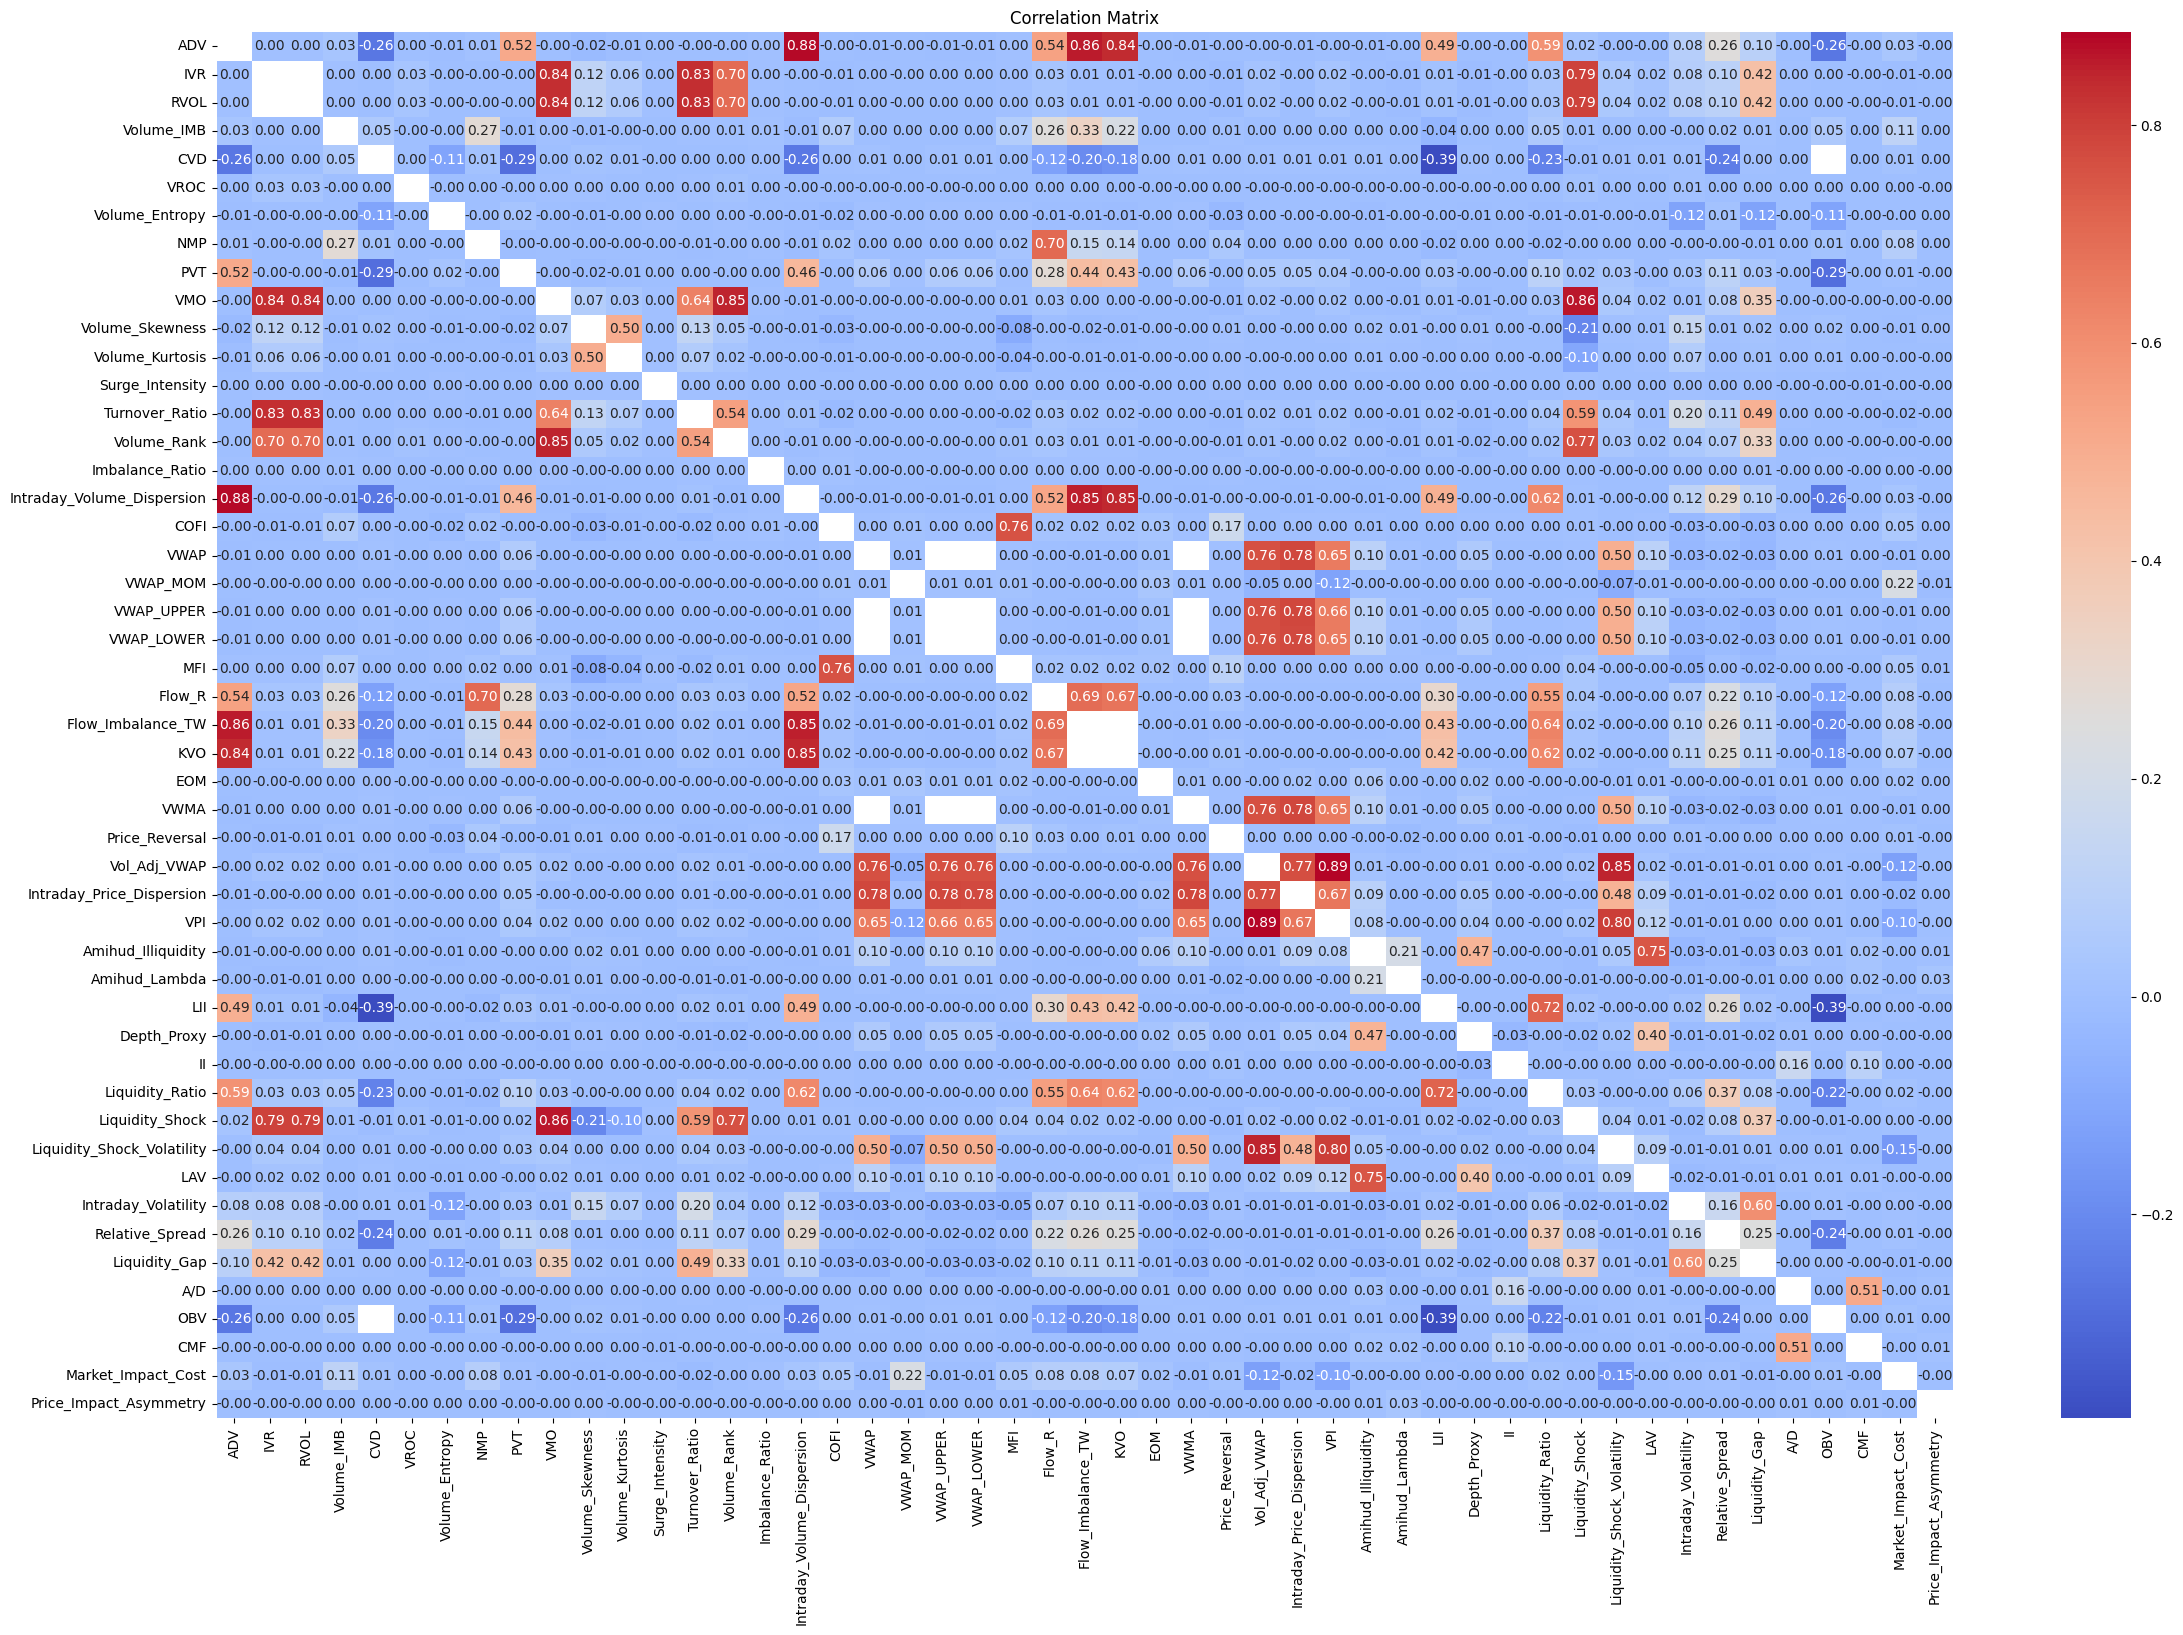

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_correlation_matrix(df, threshold=0.9):
    plt.figure(figsize=(28, 18))
    corr = df.corr()
    mask = np.abs(corr) > threshold
    sns.heatmap(corr, annot=True, fmt=".2f", mask=mask, cmap='coolwarm', cbar=True)
    plt.title('Correlation Matrix')
    plt.show()

plot_correlation_matrix(volume_df[features])

In [56]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


def remove_collinearity(df, corr_threshold=0.9, threshold=10):
    df = df.copy()

    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    collinear_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > corr_threshold)]
    df.drop(columns=collinear_features, inplace=True)

    X = df.copy().fillna(0)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    high_vif_features = vif_data[vif_data['VIF'] > threshold]['feature'].tolist()
    df.drop(columns=high_vif_features, inplace=True)

    return df

reduced_features_df = remove_collinearity(volume_df[features])
reduced_features = reduced_features_df.columns

reduced_features_df['Symbol'] = all_symbols

In [57]:
print(f"Reduced: {abs(len(features) - len(reduced_features))} features")
print(list(set(features) - set(reduced_features)))

Reduced: 9 features
['VWMA', 'KVO', 'Flow_Imbalance_TW', 'VWAP_UPPER', 'Flow_R', 'OBV', 'RVOL', 'VWAP_LOWER', 'Vol_Adj_VWAP']


In [58]:
reduced_features_df.head()

,ADV,IVR,Volume_IMB,CVD,VROC,Volume_Entropy,NMP,PVT,VMO,Volume_Skewness,...,Liquidity_Shock_Volatility,LAV,Intraday_Volatility,Relative_Spread,Liquidity_Gap,A/D,CMF,Market_Impact_Cost,Price_Impact_Asymmetry,Symbol
0,213498380.0,NaN,NaN,0.0,NaN,3.507124e-08,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,0.389238,0.001872,-0.0025,NaN,-0.0012,-0.333368,10000000AIDOGEUSDT
1,213498380.0,NaN,NaN,719649400.0,NaN,1.804164e-02,719649400.0,210041150.0,NaN,NaN,...,NaN,NaN,NaN,47.598587,0.271820,-0.0025,NaN,359345.2200,0.295814,10000000AIDOGEUSDT
2,213498380.0,NaN,NaN,-23536896.0,NaN,3.656934e-02,-743186300.0,206690270.0,NaN,NaN,...,NaN,NaN,NaN,34.956303,0.212553,-0.0025,NaN,75416.2500,0.077227,10000000AIDOGEUSDT
3,213498380.0,NaN,NaN,-345262800.0,NaN,4.576091e-02,-321725900.0,194043970.0,NaN,NaN,...,NaN,NaN,NaN,13.842944,0.083852,-0.0025,NaN,-38096.6800,-0.237778,10000000AIDOGEUSDT
4,213498380.0,NaN,NaN,-554846400.0,NaN,5.213907e-02,-209583600.0,187903630.0,NaN,NaN,...,NaN,NaN,NaN,12.622352,0.076149,-0.0025,NaN,-56143.6520,-0.610210,10000000AIDOGEUSDT


In [59]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

segment_length = 512
overlap = 128

def segment_by_symbol_and_save(df, features, segment_length, overlap):
    symbols = df['Symbol'].unique()

    print("NaN values before imputation:\n", df.isna().sum())
    imputer = SimpleImputer(strategy='constant', fill_value=0.0)
    df[features] = imputer.fit_transform(df[features])

    symbol_sequences = [df[df['Symbol'] == symbol][features].to_numpy() for symbol in symbols]
    print("Symbol seq: ", len(symbol_sequences))

    def segment_sequence(sequence, segment_length, overlap, pad_left=False):
        segments = []
        step = segment_length - overlap

        for start in range(0, len(sequence), step):
            end = min(start + segment_length, len(sequence))
            segment = sequence[start:end]

            if len(segment) < segment_length:
                pad_width = segment_length - len(segment)

                if pad_left:
                    segment = np.pad(segment, ((pad_width, 0), (0, 0)), 'constant')
                else:
                    segment = np.pad(segment, ((0, pad_width), (0, 0)), 'constant')

            segments.append(segment)

        return segments

    def segment_all_sequences(sequences, segment_length, overlap):
        segmented_sequences = []
        segment_symbol_indices = []
        for symbol_idx, seq in enumerate(sequences):
            segments = segment_sequence(seq, segment_length, overlap)
            segmented_sequences.extend(segments)
            segment_symbol_indices.extend([symbol_idx] * len(segments))
        return segmented_sequences, segment_symbol_indices

    segmented_sequences, segment_symbol_indices = segment_all_sequences(symbol_sequences, segment_length=segment_length, overlap=overlap)
    segmented_sequences = np.array(segmented_sequences)

    n_segments, segment_length, n_features = segmented_sequences.shape

    scaler = StandardScaler()
    segmented_sequences = segmented_sequences.reshape(-1, n_features)
    normalized_segments = scaler.fit_transform(segmented_sequences)
    normalized_segments = normalized_segments.reshape(n_segments, segment_length, n_features)

    print("Shape of normalized features:", normalized_segments.shape)
    print("Number of symbols:", n_symbols)

    np.save(features_filename, normalized_segments)
    np.save(symbol_indices_filename, segment_symbol_indices)

segment_by_symbol_and_save(reduced_features_df, reduced_features, segment_length=segment_length, overlap=overlap)

NaN values before imputation:
 ADV                                 0
IVR                              7809
Volume_IMB                       5343
CVD                                 0
VROC                             9955
Volume_Entropy                      0
NMP                                 0
PVT                                 1
VMO                              5343
Volume_Skewness                  5343
Volume_Kurtosis                  5343
Surge_Intensity                 13152
Turnover_Ratio                      0
Volume_Rank                      7809
Imbalance_Ratio                  5343
Intraday_Volume_Dispersion    2437542
COFI                             5343
VWAP                                0
VWAP_MOM                          411
MFI                              5343
EOM                              5344
Price_Reversal                      0
Intraday_Price_Dispersion     2437542
VPI                             84069
Amihud_Illiquidity                  0
Amihud_Lambda      

In [13]:
from notebooks.pipelines import ocean_train

epochs = 1
latent_dim = 32
lr = 1e-4

ocean_train.run_training(
    features_filename=features_filename,
    emb_filename=emb_filename,
    epochs=epochs,
    latent_dim=latent_dim,
    lr=lr,
)

RANK: 0, WORLD_SIZE: 1
Loaded snapshot: snapshots/AutoEncoder_epoch_63_improved.pth
Start training with epochs 1
Epoch [1/1], Train Loss: 0.49372853
Saved improved snapshot: snapshots/AutoEncoder_epoch_1_improved.pth
Training Complete
Loaded snapshot: snapshots/AutoEncoder_epoch_1_improved.pth
Embeddings shape: (20992, 32)


In [13]:
def create_emb(symbols):
    embeddings = np.load(emb_filename)
    segment_symbol_indices = np.load(symbol_indices_filename)

    print("Embedding shape:", embeddings.shape)
    print("Symbol Idx shape:", segment_symbol_indices.shape)

    symbol_embeddings_dict = {symbol: [] for symbol in symbols}

    for i, symbol_idx in enumerate(segment_symbol_indices):
        symbol = symbols[symbol_idx]
        symbol_embeddings_dict[symbol].append(embeddings[i])

    df = pd.DataFrame({
        'symbol': symbol_embeddings_dict.keys(),
        'embeddings': symbol_embeddings_dict.values()
    })

    return df

res_df = create_emb(symbols)

print("DF shape:", res_df.shape)
print("\n", res_df.head())

Embedding shape: (20992, 32)
Symbol Idx shape: (20992,)
DF shape: (411, 2)

                 symbol                                         embeddings
0   10000000AIDOGEUSDT  [[0.19126573, -0.08868953, 0.35082957, 0.11171...
1  1000000BABYDOGEUSDT  [[-0.07357137, 0.13716264, 0.059593532, 0.1557...
2       1000000MOGUSDT  [[0.23299173, -0.13537292, 0.18171357, 0.09532...
3    1000000PEIPEIUSDT  [[-0.11181599, 0.11376472, 0.026071629, 0.2061...
4         10000COQUSDT  [[0.19453976, -0.23962377, 0.2065886, -0.02613...


In [14]:
all_embeddings = np.vstack(res_df['embeddings'].values)
all_embeddings.shape

(20992, 32)

/Users/siarheimelnik/Projects/quant-prod/.venv/lib/python3.12/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/Users/siarheimelnik/Projects/quant-prod/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


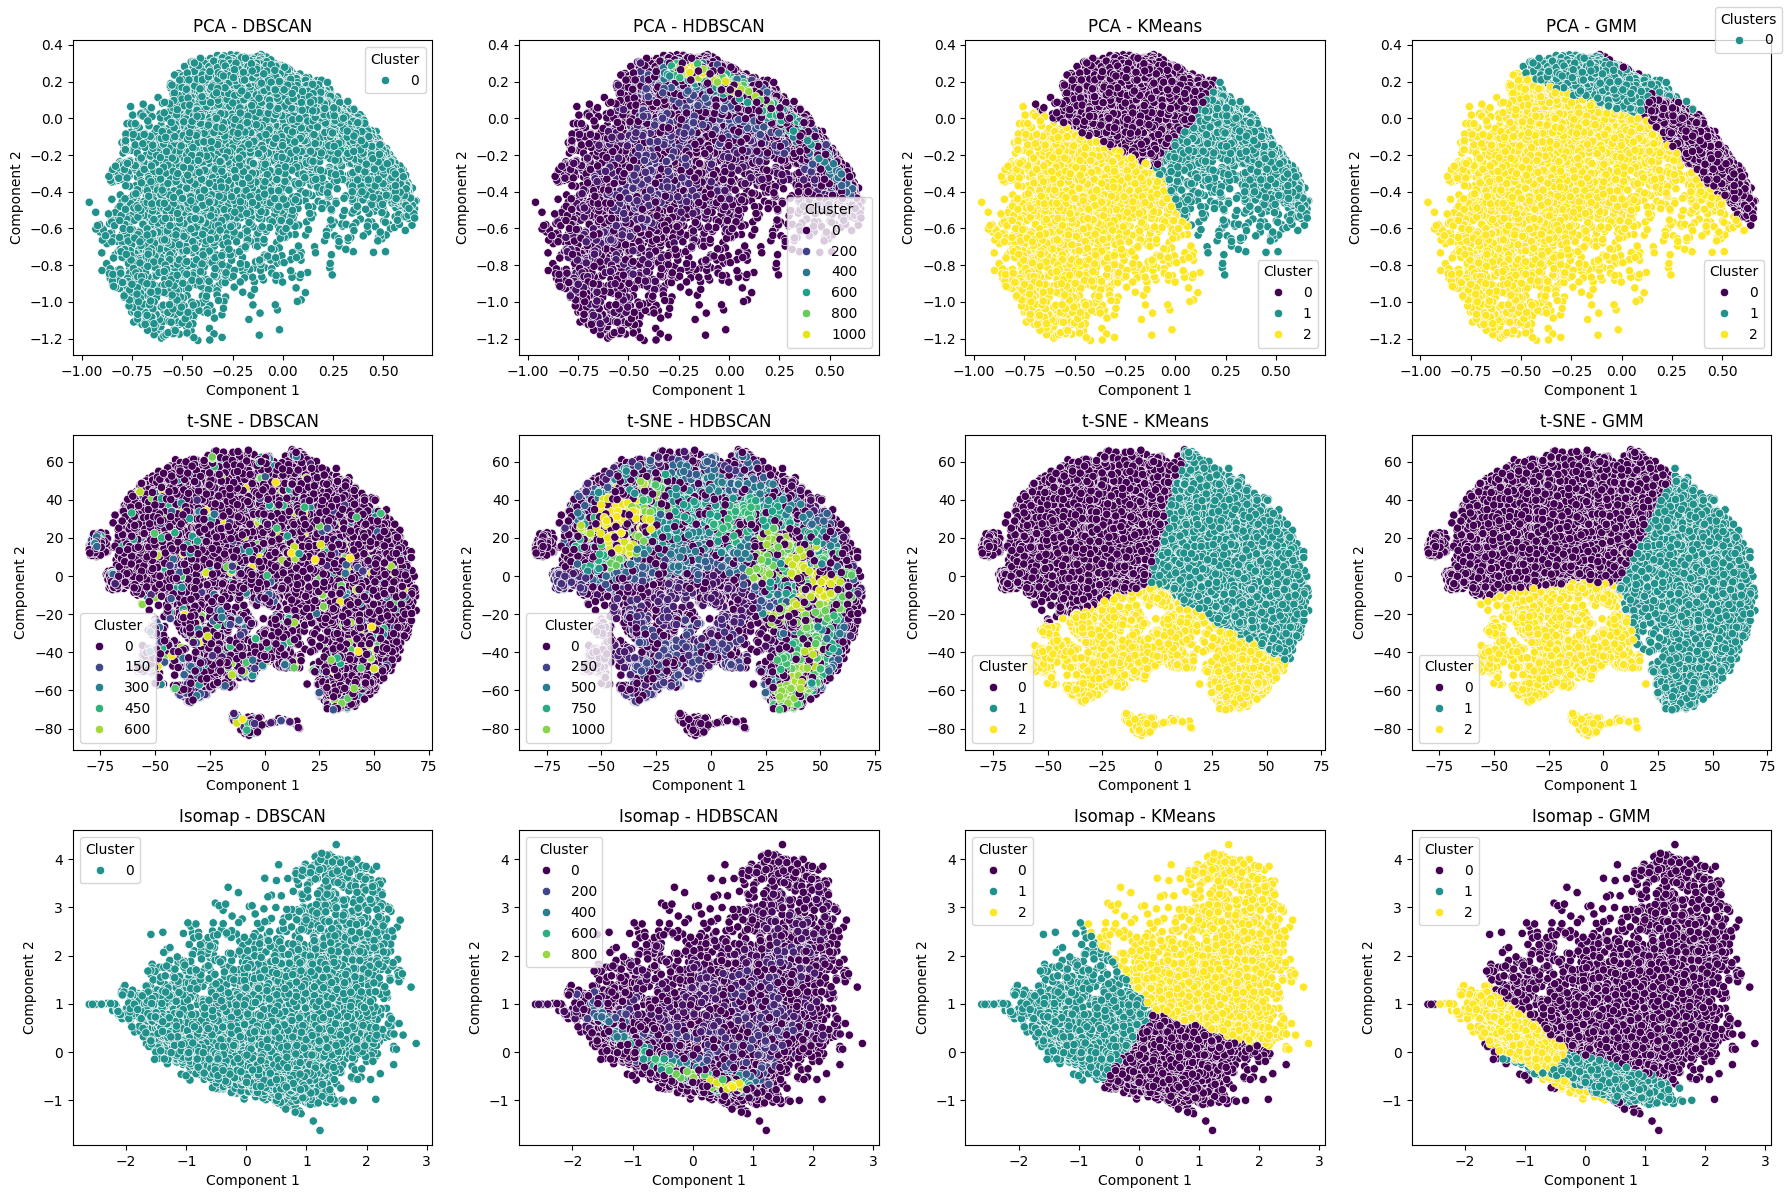

In [16]:
from sklearn.cluster import DBSCAN, HDBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
from sklearn.mixture import GaussianMixture

n_clusters = 3
n_components = 2

def visualize_clustering(all_embeddings, n_clusters=3, n_components=2, random_state=1337):
    clustering_methods = {
        "DBSCAN": DBSCAN(),
        "HDBSCAN": HDBSCAN(),
        "KMeans": KMeans(n_clusters=n_clusters),
        "GMM": GaussianMixture(n_components=n_clusters),
    }

    dimensionality_methods = {
        "PCA": PCA(n_components=n_components, random_state=random_state),
        "t-SNE": TSNE(n_components=n_components, random_state=random_state),
        "Isomap": Isomap(n_components=n_components),
        # "MDS": MDS(n_components=n_components),
        # "Factor Analysis": FactorAnalysis(n_components=n_components),
    }

    fig, axes = plt.subplots(len(dimensionality_methods), len(clustering_methods), figsize=(18, 12))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)

    for i, (dim_name, dim_method) in enumerate(dimensionality_methods.items()):
        reduced_embeddings = dim_method.fit_transform(all_embeddings)

        for j, (cluster_name, cluster_method) in enumerate(clustering_methods.items()):
            cluster_labels = cluster_method.fit_predict(reduced_embeddings)

            df = pd.DataFrame(reduced_embeddings, columns=['Component 1', 'Component 2'])
            df['Cluster'] = cluster_labels

            sns.scatterplot(data=df, x='Component 1', y='Component 2', hue='Cluster', palette='viridis', ax=axes[i, j], legend='auto')
            axes[i, j].set_title(f'{dim_name} - {cluster_name}')
            axes[i, j].set_xlabel('Component 1')
            axes[i, j].set_ylabel('Component 2')

    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Clusters', loc='upper right')

    plt.tight_layout()
    plt.show()

visualize_clustering(all_embeddings, n_clusters=n_clusters, n_components=n_components, random_state=seed)

In [16]:
from sklearn.decomposition import PCA

def adjust_embedding_length(emb, target_length):
    emb = np.array(emb)

    if len(emb) < target_length:
        pad_width = target_length - len(emb)
        return np.pad(emb, (0, pad_width), 'constant')

    return emb[:target_length]

def flat_embeddings(df):
    df = df.copy()

    df['flat_embeddings'] = df['embeddings'].apply(lambda emb: [val for sublist in emb for val in sublist])

    embedding_lengths = df['flat_embeddings'].apply(len)
    max_length = embedding_lengths.max() if not embedding_lengths.empty else 0

    df['flat_embeddings'] = df['flat_embeddings'].apply(lambda emb: adjust_embedding_length(emb, max_length))

    return df

def reduce_embeddings(df, n_reduced=10):
    df = df.copy()

    flat_embeddings = np.array(df['flat_embeddings'].tolist())

    pca = PCA(n_components=n_reduced)
    reduced_embeddings = pca.fit_transform(flat_embeddings)

    df['reduced_embeddings'] = list(reduced_embeddings)

    reduced_lengths = df['reduced_embeddings'].apply(len)
    reduced_uniq_lengths = reduced_lengths.value_counts()

    print("Reduced embedding lengths and counts:")
    print(reduced_uniq_lengths)

    return df

def optimal_n_components(df, threshold=0.90):
    flat_embeddings = np.array(df['flat_embeddings'].tolist())

    pca = PCA()
    pca.fit(flat_embeddings)

    cumulative_variance = pca.explained_variance_ratio_.cumsum()

    n_components = np.argmax(cumulative_variance >= threshold) + 1
    return n_components

flat_emb_df = flat_embeddings(res_df)
n_reduced = optimal_n_components(flat_emb_df)
print(f"n_components: {n_reduced}")

reduce_emb_df = reduce_embeddings(flat_emb_df, n_reduced=n_reduced)

simularity_values = reduce_emb_df[['symbol', 'reduced_embeddings']].values
print('\n', simularity_values[0])

np.save(f"out/{res_filename}", simularity_values)

n_components: 209
Reduced embedding lengths and counts:
reduced_embeddings
209    411
Name: count, dtype: int64

 ['10000000AIDOGEUSDT'
 array([ 0.3245787 ,  0.72893095,  1.3981669 ,  0.2852623 ,  0.9231718 ,
         0.05376071, -0.31529984,  0.5981512 ,  0.27240878,  0.07267477,
         0.82440513,  0.39447728,  0.6249002 , -0.15764615, -0.30017695,
        -0.09686919,  0.51875716, -0.02387194, -0.27578267,  0.5651581 ,
         0.01682553,  0.15010673, -0.46887565,  0.31012088, -0.62790674,
         0.39187354,  0.09138607,  0.62897706, -0.1140606 , -0.02328452,
         0.29696706, -0.20893139,  0.18826449,  0.11260098,  0.1006506 ,
        -0.3609758 , -0.17114703, -0.11771031,  0.13633071, -0.40438864,
        -0.14129066,  0.02857034, -0.22967422,  0.0383278 , -0.31725326,
         0.11982481, -0.05769806,  0.00762478,  0.20037411, -0.32595295,
         0.61149704,  0.28759128,  0.12216963,  0.14684486, -0.26051286,
         0.14553328, -0.20274949,  0.3625902 ,  0.34853485, -

In [17]:
from ocean import SIM

max_level = 8
max_neighbors = 40
ef_construction = 500
ef_search = 50

gsim = SIM(
    max_level=max_level,
    max_neighbors=max_neighbors,
    ef_construction=ef_construction,
    ef_search=ef_search
)

embs = np.load(f"out/{res_filename}", allow_pickle=True)

for symbol, emb in embs:
    gsim.insert(emb, symbol)

gsim.perform_clustering()

In [18]:
from core.models.cap import CapType

symbol = 'SOLUSDT'
val = reduce_emb_df[reduce_emb_df['symbol'] == symbol]['reduced_embeddings'].values
query = val[0]

print(f"Symbol: {symbol}")

neighbors = gsim.search(query, 8)
n_neighbors = len(neighbors)

print(f"Found {n_neighbors} nearest neighbors for the query.")

for i, neighbor in enumerate(neighbors):
    dist, node = neighbor
    print(f"{i} neighbor Symbol: {node.meta['symbol']}")

simular_symbols = gsim.find_similar_symbols(symbol, 4)
n_symbols = len(simular_symbols)

print(f"Found {n_symbols} simular symbols")

for symbol in simular_symbols:
    print(f"Symbol: {symbol}")

cap = CapType.A
cap_symbols = gsim.find_similar_by_cap(cap, top_k=18)
n_symbols = len(cap_symbols)

print(f"Found {n_symbols} symbols by: {cap.name}")

for symbol in cap_symbols:
    print(f"Symbol: {symbol}")

Symbol: SOLUSDT
Found 8 nearest neighbors for the query.
0 neighbor Symbol: SOLUSDT
1 neighbor Symbol: REEFUSDT
2 neighbor Symbol: OPUSDT
3 neighbor Symbol: RENUSDT
4 neighbor Symbol: JOEUSDT
5 neighbor Symbol: TIAUSDT
6 neighbor Symbol: REQUSDT
7 neighbor Symbol: STGUSDT
Found 4 simular symbols
Symbol: REEFUSDT
Symbol: OPUSDT
Symbol: RENUSDT
Symbol: JOEUSDT
Found 18 symbols by: A
Symbol: OPUSDT
Symbol: REEFUSDT
Symbol: MASAUSDT
Symbol: UNFIUSDT
Symbol: RAREUSDT
Symbol: JOEUSDT
Symbol: RENUSDT
Symbol: 10000000AIDOGEUSDT
Symbol: TIAUSDT
Symbol: QTUMUSDT
Symbol: OXTUSDT
Symbol: SFPUSDT
Symbol: TUSDT
Symbol: SUNUSDT
Symbol: RLCUSDT
Symbol: SHIB1000USDT
Symbol: PAXGUSDT
Symbol: STGUSDT
